# Question 2

In [ ]:
#imports
library(readr)
library(tigerstats)
library(ggplot2)
library(gridExtra)
library("DESeq2")
library("vsn")
library("pheatmap")
library("RColorBrewer")
library(repr)

In [2]:
#load data
cd <- read_tsv("clinical-data.tsv") 
mc <- read_tsv("morphological-counts.tsv")


Rows: 136 Columns: 12
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr (5): SMPLID, SMPTHNTS, COHORT, SUBJID, IMGURL
dbl (7): SEX, AGE, HGHT, WGHT, BMI, TRISCHD, DTHHRDY

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 136 Columns: 65
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr  (1): SMPLID
dbl (64): Mophological.cluster.0, Mophological.cluster.1, Mophological.clust...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#normalisation pour les variables numériques et changement de type pour les variable catégorielles 
numerical_variables <- list('AGE', 'HGHT', 'WGHT', 'BMI', 'TRISCHD') 
categorical_variables <- list('SEX', 'COHORT', 'DTHHRDY')
for (variable in numerical_variables){
    cd[variable] <- scale(cd[variable])
}
for (variable in categorical_variables){
    cd[variable] <- factor(cd[[variable]])
}

In [ ]:
cd

## Pré-analyses

### Corrélation moyenne-variance

In [ ]:
#Dans l'article sur DESseq2 ils parlent du fait qu'avec les rna counts on a une corrélation entre la moyenne de l'expression
#d'un gêne et sa variance, et du coup il vaut mieux faire une normalisation, par exemple pour les pca etc. du coup je voulais
#vérifier si c'est le cas aussi avec les cluster counts mais il semble que non
#après, ça ne veut pas nécessairement dire qu'il ne faut pas quand même faire de normalisation 

means <- colMeans(mc_red)
sdev <- sapply(mc_red, sd)

plot(means, sdev)
cor(means, sdev)

In [ ]:
meanSdPlot(t(data.matrix(mc_red)), ranks=FALSE)

In [ ]:
#par comparaison, faisons la même chose avec les rna counts
rna =  read_tsv("RNA-read-counts.tsv")
rna
meanSdPlot(t(data.matrix(rna)), ranks=FALSE)


In [ ]:
mrna <- rna[,3:65]
means <- colMeans(mrna)
sdev <- sapply(mrna, sd)

plot(means, sdev)
cor(means, sdev)

#on voit que la corrélation est beaucoup plus élevée

### Création de l'objet DESeqDataSet

In [ ]:
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ AGE)


### Sample distances

In [ ]:
#pas encore sur de quoi faire avec ça mais je me disais qu'on pourrait peut-être faire quelque chose avec une matrice
#des distances entre samples
sampleDists <- dist(t(assay(dds)))
sampleDists

In [ ]:
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( cd$SMPLID )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
options(repr.plot.width=16, repr.plot.height=16)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

### Corrélations des clusters morphologiques entre eux

In [ ]:
corr <- cor(st_mc)
corr <- abs(corr)
corr[corr==1.0]<-0.0
max(corr)
#j'ai pas été loin dans l'analyse de la matrice de corrélation pour l'instant, mais avec une corrélation max de 0.88 on 
#pourrait éventuellement envisager d'éliminer les clusters les plus corrélés

### PCA des clusters

In [ ]:
pca = prcomp(st_mc)
colors <- rep("black", 136)
colors[cd$SEX == 1] <- "red"
plot(pca$x[, 1:2], col=colors)

## Analyse de l'expression différentielle

In [4]:
#assoc_table va être une matrice ou on voit pour chaque variable quel cluster est différentiellement exprimé
row <- colnames(cd)[2:10]
row <- row[-6]

col <- colnames(mc[,2:65])
assoc_table <- data.frame(matrix(ncol = 64, nrow = 8))
colnames(assoc_table) <- col
rownames(assoc_table) <- row
assoc_table[,] <- FALSE
assoc_table

,Mophological.cluster.0,Mophological.cluster.1,Mophological.cluster.2,Mophological.cluster.3,Mophological.cluster.4,Mophological.cluster.5,Mophological.cluster.6,Mophological.cluster.7,Mophological.cluster.8,Mophological.cluster.9,...,Mophological.cluster.54,Mophological.cluster.55,Mophological.cluster.56,Mophological.cluster.57,Mophological.cluster.58,Mophological.cluster.59,Mophological.cluster.60,Mophological.cluster.61,Mophological.cluster.62,Mophological.cluster.63
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,...,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
SEX,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AGE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
HGHT,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WGHT,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
BMI,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
COHORT,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TRISCHD,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
DTHHRDY,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


#### Sex

In [5]:
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ SEX)


converting counts to integer mode



In [6]:
# calcul des expressions différentielles
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 10 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [7]:
res <- results(dds)
resultsNames(dds)
res
summary(res)

[1] "Intercept"  "SEX_2_vs_1"

log2 fold change (MLE): SEX 2 vs 1 
Wald test p-value: SEX 2 vs 1 
DataFrame with 65 rows and 6 columns
                         baseMean log2FoldChange     lfcSE      stat    pvalue
                        <numeric>      <numeric> <numeric> <numeric> <numeric>
SMPLID                    72.9315       0.194895  0.214459  0.908774 0.3634695
Mophological.cluster.0   105.4915       0.393762  0.194342  2.026128 0.0427517
Mophological.cluster.1   103.7647       0.186658  0.230576  0.809531 0.4182099
Mophological.cluster.2   117.1776       0.169954  0.244563  0.694930 0.4870990
Mophological.cluster.3   125.2827       0.494131  0.226603  2.180604 0.0292128
...                           ...            ...       ...       ...       ...
Mophological.cluster.59   13.8445      0.2001548  0.408155  0.490390 0.6238581
Mophological.cluster.60  126.7505      0.3583921  0.194006  1.847321 0.0647006
Mophological.cluster.61  139.2785     -0.1050435  0.275162 -0.381752 0.7026454
Mophological.cluster.62  15


out of 65 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 14, 22%
LFC < 0 (down)     : 1, 1.5%
outliers [1]       : 0, 0%
low counts [2]     : 2, 3.1%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [8]:
#pour voir le nombre de clusters pour lesquels la p-value est inférieure à 0.05
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)


FALSE  TRUE 
   58     7 

In [23]:
#Voir les 7 clusters avec la p-value ajustée en dessous de 0.05
resSig <- subset(res, padj < 0.05)
resSig[ order(resSig$log2FoldChange), ]


log2 fold change (MLE): SEX 2 vs 1 
Wald test p-value: SEX 2 vs 1 
DataFrame with 7 rows and 6 columns
                         baseMean log2FoldChange     lfcSE      stat
                        <numeric>      <numeric> <numeric> <numeric>
Mophological.cluster.28  154.2311       0.611144  0.215170   2.84029
Mophological.cluster.29   71.3152       0.672496  0.225778   2.97857
Mophological.cluster.57  114.7111       0.944129  0.282605   3.34081
Mophological.cluster.18   79.0266       1.053218  0.268311   3.92536
Mophological.cluster.38   92.7315       1.073725  0.294151   3.65026
Mophological.cluster.42  108.5923       1.816409  0.393394   4.61728
Mophological.cluster.36  116.7020       2.803487  0.460505   6.08786
                             pvalue        padj
                          <numeric>   <numeric>
Mophological.cluster.28 4.50729e-03 4.05656e-02
Mophological.cluster.29 2.89601e-03 3.04081e-02
Mophological.cluster.57 8.35347e-04 1.05254e-02
Mophological.cluster.18 8.65987e-05 

[1] "Mophological.cluster.18" "Mophological.cluster.28"
[3] "Mophological.cluster.29" "Mophological.cluster.36"
[5] "Mophological.cluster.38" "Mophological.cluster.42"
[7] "Mophological.cluster.57"

In [11]:
#on remplit la colonne SEX dans assoc_table
assoc_table["SEX",] <- colnames(assoc_table) %in% rownames(resSig)
print(assoc_table['SEX',])

    Mophological.cluster.0 Mophological.cluster.1 Mophological.cluster.2
SEX                  FALSE                  FALSE                  FALSE
    Mophological.cluster.3 Mophological.cluster.4 Mophological.cluster.5
SEX                  FALSE                  FALSE                  FALSE
    Mophological.cluster.6 Mophological.cluster.7 Mophological.cluster.8
SEX                  FALSE                  FALSE                  FALSE
    Mophological.cluster.9 Mophological.cluster.10 Mophological.cluster.11
SEX                  FALSE                   FALSE                   FALSE
    Mophological.cluster.12 Mophological.cluster.13 Mophological.cluster.14
SEX                   FALSE                   FALSE                   FALSE
    Mophological.cluster.15 Mophological.cluster.16 Mophological.cluster.17
SEX                   FALSE                   FALSE                   FALSE
    Mophological.cluster.18 Mophological.cluster.19 Mophological.cluster.20
SEX                    TRUE     

### Numerical variables

In [24]:
#fonction pour remplir la ligne du tableau 'assoc_table' associée avec une variable clinique numérique
num_dif_exp <- function(condition, assoc_table){
    cond <- as.formula(paste("~", condition))
    print(cond)
    dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = cond)
    dds <- DESeq(dds)
    res <- results(dds)
    res.05 <- results(dds, alpha = 0.05)
    resSig <- subset(res, padj < 0.05)
    print(rownames(resSig))
    assoc_table[condition,] <<- colnames(assoc_table) %in% rownames(resSig)
}

In [25]:
for(variable in numerical_variables){
    num_dif_exp(variable, assoc_table)}

~AGE
<environment: 0x000000004f9a6688>


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



~HGHT
<environment: 0x00000000076ccc38>


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



~WGHT
<environment: 0x000000000f8917d0>


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



~BMI
<environment: 0x000000004efb09d8>


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



~TRISCHD
<environment: 0x00000000505ffe28>


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



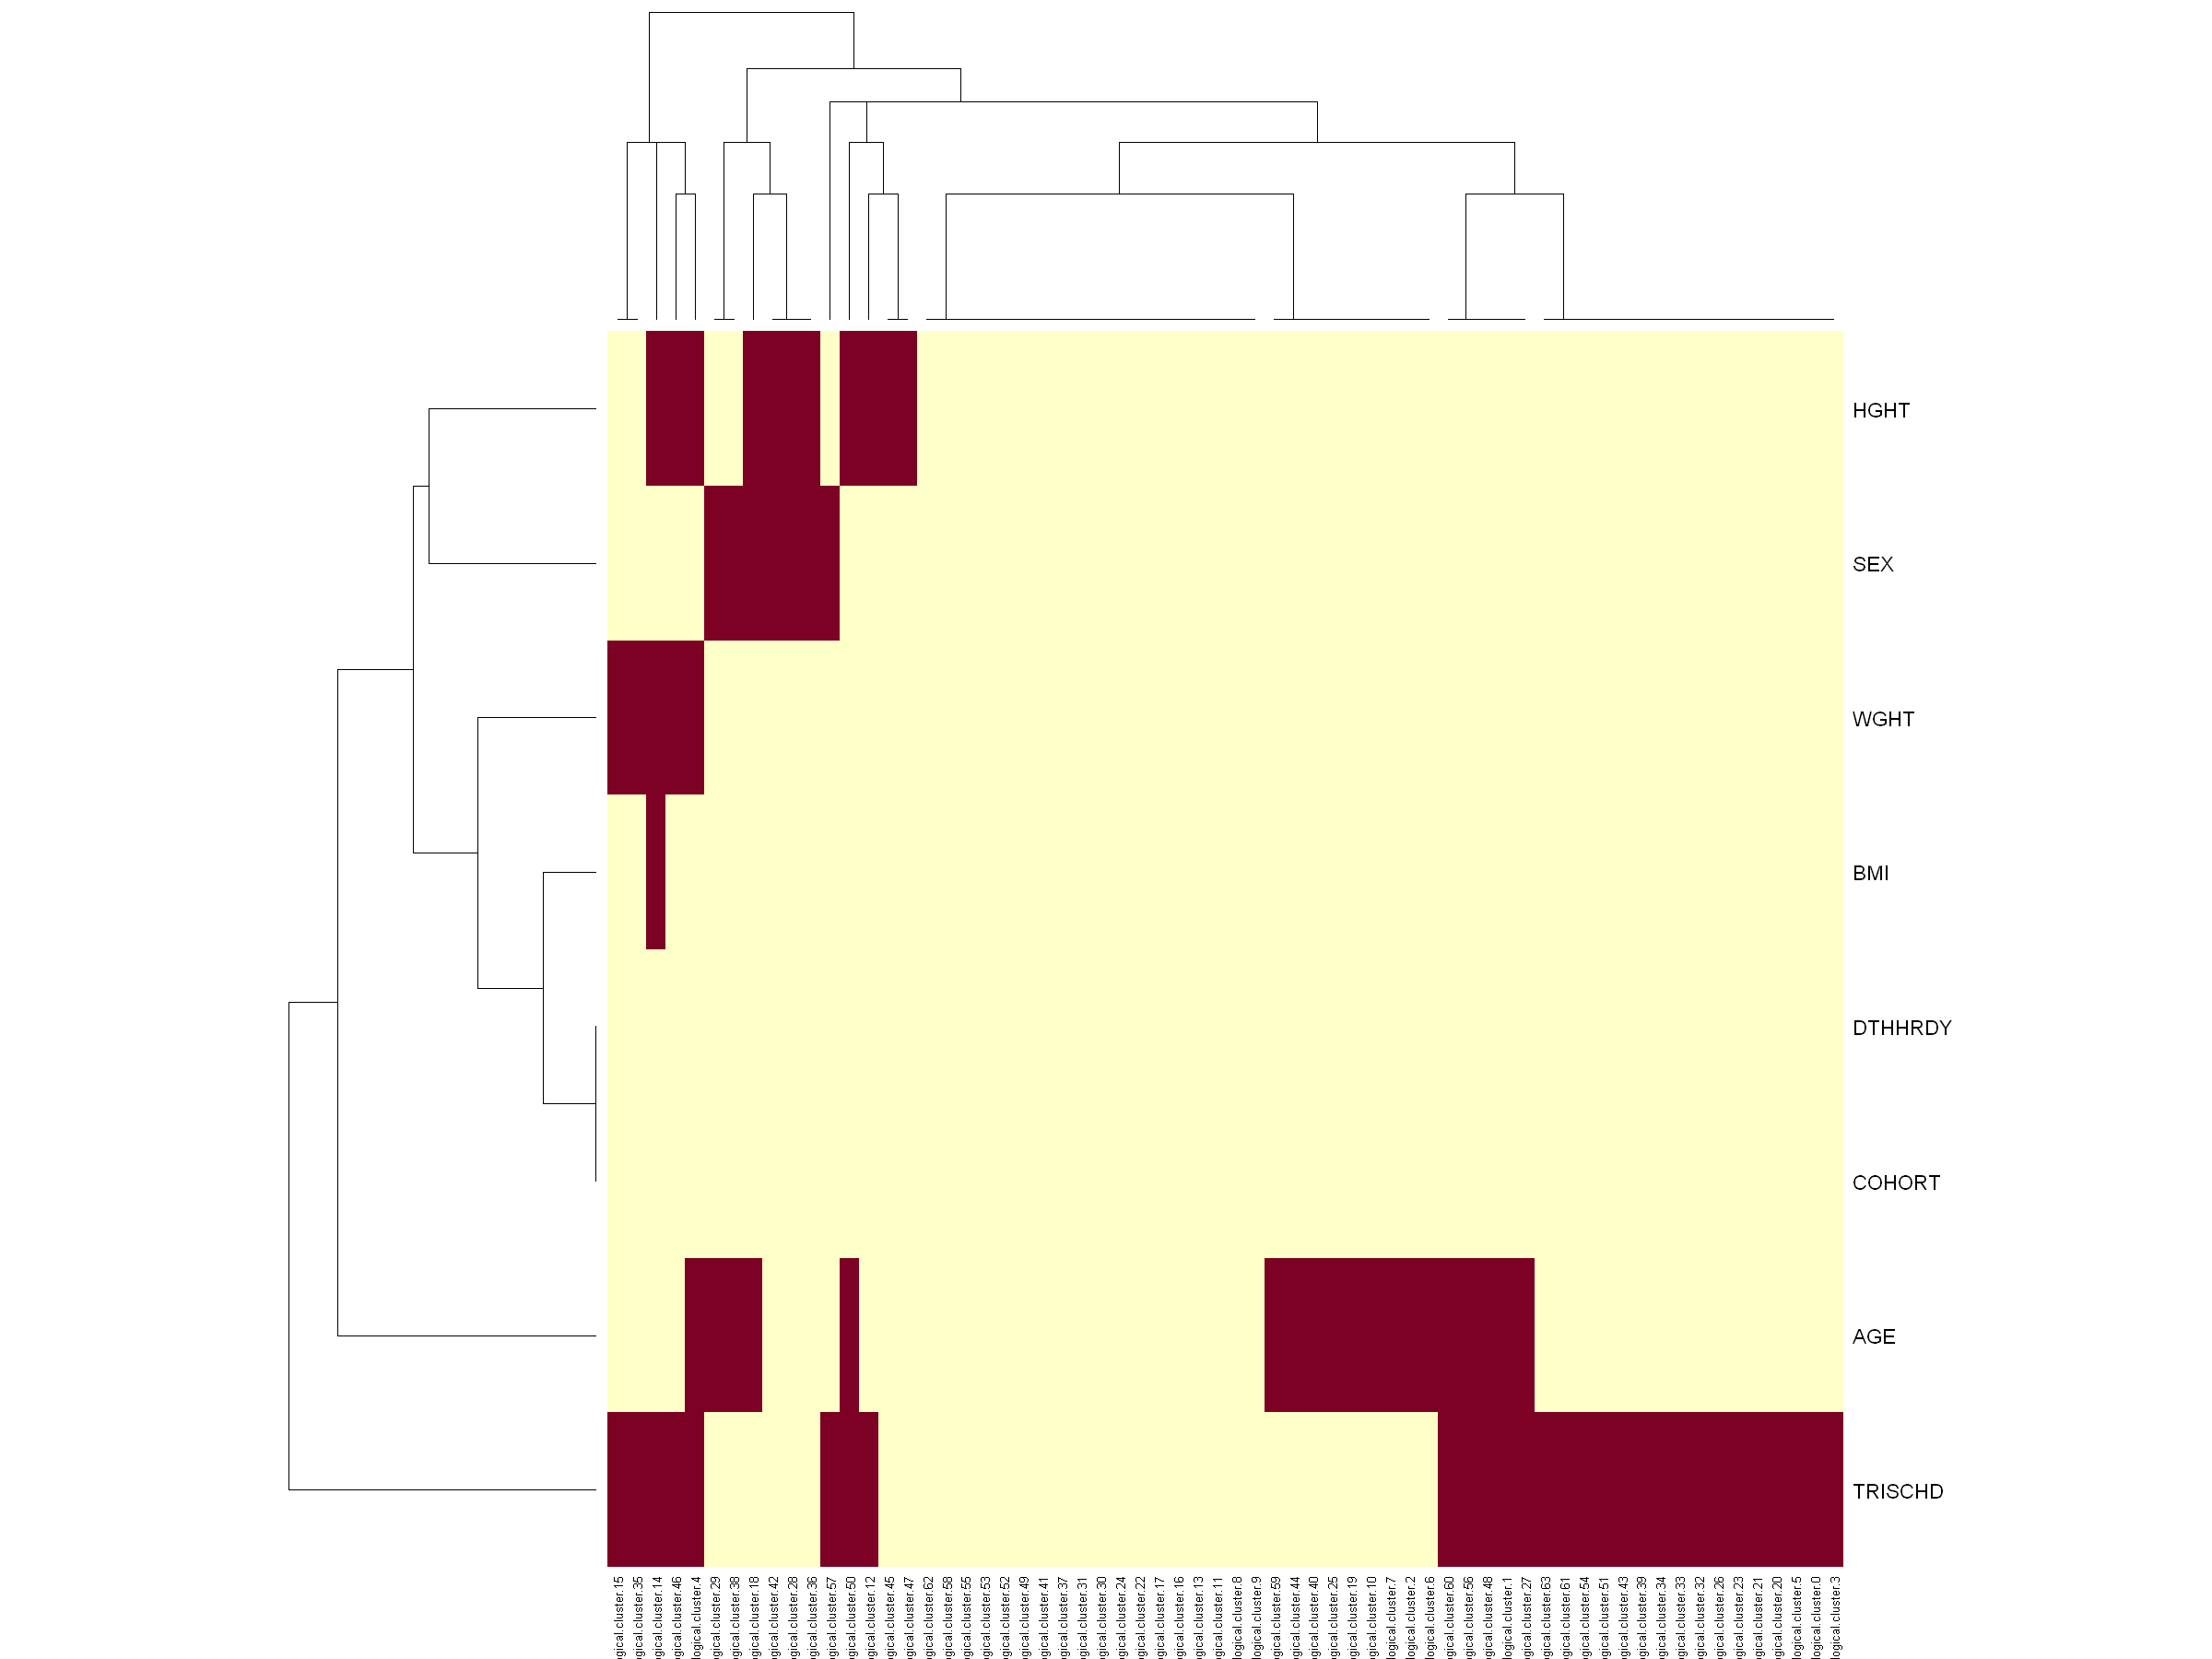

In [45]:
options(repr.plot.width=20, repr.plot.height=15)
heatmap(data.matrix(assoc_table), scale='none')

#### Age

In [ ]:
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~AGE)


In [ ]:
dds <- DESeq(dds)
res <- results(dds)
resultsNames(dds)
res
summary(res)

In [ ]:
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)
resSig <- subset(res, padj < 0.05)
resSig[ order(resSig$log2FoldChange), ]
assoc_table[2,] <- colnames(assoc_table) %in% rownames(resSig)
assoc_table